This notebook demonstrates the step-size inversion phenomenon discussed in the paper "Asymptotic Network Independence and Step-Size for a Distributed Subgradient Method." The code provided here will generated Figure 2 of that paper. 

First, we set the various parameters. 

In [1]:
import numpy as np 
N = 9; #number of agents
m = 1;  #number of data points per agent 
d = 2;  #dimension 

In [2]:
times = 1000;                                                              #number of times we will run the optimization method to determine each data point
stepsizes = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]; #we will use step-sizes that go as 1/k^a, where a is an element of this array
L = len(stepsizes)
results = np.zeros(L);                                                 #since there are 11 step-sizes, the final result will be an array with 11 entries 
lambda1 = 1
lambda2 = 1/20
ones_vector = np.ones(d)


Since the optimization problem is done over the [0,1]^d, it will be useful to have a couple of functions projecting points onto the unit cube. The two functions below do this. The first one projects a numpy array of dimension dim,
and the second one projects a scalar.

In [3]:
def projcubenp(x,dim):
  for i in range(dim):
    if x[i] > 1:
      x[i]=1

    if x[i] < -1:
      x[i]=-1
  
  return x

In [4]:
def projcubescalar(x):
  if x > 1:
    x=1
  if x < -1:
    x=-1
  return x

This function computes the subgradient of the function 

f(point) = (1/40)*(point^T x - y)^4 + lambda_1||point||_2^2 + lambda_2 ||point||_1 

that subgradient is clearly equal to 

(1/4) (point^T x - y)^3 point + 2 lambda_1 point + lambda_2 sign(point) 

In [5]:
def compute_grad_elastic(point, x, y, lambda1, lambda2):
  # point is theta
  #x is a_i
  #y is b_i
  #lambda1, lambda2 are themselves
  sign  = np.sign(point)
  diff = np.matmul(point,x) - y
  y = (1/10)*(diff ** 3)*x + 2*lambda1*point + lambda2*sign

  return y

Finally, it will be useful to have the following "double sided relu" function which is zero when the absolute value of x is below N, and outside that range equals |x|-N

In [6]:
def reluN(x,U): 
  
  if np.absolute(x) < U:
    return 0
  else:
    return np.absolute(x) - U

Finally, the following package will be used to track progress as we execute the method.

In [7]:
!pip install enlighten

The following is the main loop of the "centralized" method. That is, each iteration of the method will just loop over the data of every agent. This only makes sense under the assumption that this is possible, i.e., a centralized agent can simply access the data of each agent. This method serves as a benchmark to what the distributed method is later compared. 

In [8]:
import enlighten

manager = enlighten.get_manager()
ticks = manager.counter(total=L, desc="Outer Loop", unit="Iterations", color="red")


for a in range(L):  #there are 11 step-sizes and we loop over them. 
    ticks.update()
    record = np.zeros(times) #this array will contain an entry for every time we run the method 
    tocks = manager.counter(total=times, desc="Inner Loop", unit="Iterations", color="blue")
    for b in range(times): #this loop will fill the "record" array
        
        tocks.update()

        X = np.random.rand(m*d,N) #generate random data 
                                  #this is the a_i in the paper
                                  #each column of this array corresponds to information held by an agent
                                  #thus there are N columns
                                  #each column holds m data points of dimension d

        
        #the next loop generates the quantities b_i from the paper, which we stack into the vector y
        y = np.zeros((m,N)) #there are N agents, each has m data points, so y is m x N
        for i in range(N):
          for j in range(m):
            Xextracted = X[j*d:(j+1)*d,i] #this is x_i
            y[j,i] = np.matmul(ones_vector, Xextracted) + 2*np.random.standard_normal() #y_i = 1^T x_i + w_i 
                                                                                      #this is the all-ones vector is going to be very close to the optimal solution



        #now we setup the main loop

        seqerror = 1 #this quantity will measure the norm of the subgradient
        k=1          #variable counting how many iterations we have done

        xprev = np.zeros(d) #initial point
        runavg = xprev      #running average of iterates

        while seqerror > 3e-2: #as long as the error is large, we keep iterating 

              #first step is to compute the gradient at the current point, which is xprev
              grad = np.zeros(d) #initialize to zero

              #sum over all the agents and all the data held by the agents
              for i in range(N):
                for j in range(m):
                  Xextracted = X[j*d:(j+1)*d,i]
                  temp_grad = compute_grad_elastic(xprev, Xextracted, y[j,i], lambda1, lambda2)
                  grad += temp_grad 
                
              #step-size at this iteration

              alpha = 1/( k ** stepsizes[a])

              #the main update: projected gradient descent
              x = projcubenp(xprev - alpha*(1/(N*m))*grad, d) #note the slightly lopsided way we computed the gradient:
                                                              #we sum up over K points, then divide by K
                                                              #thus the ||theta||_2^2 and ||theta||_1 terms get added K times
                                                              #and then get divided by K

              runavg = (1-alpha)*runavg + alpha*x            #update the running average 


              #next, we will compute the gradient at the running average 
              #we will stop when this is close to zero 
              #the rule we use will be explained in the text box after the code 
              #for now note that this code below computes 
              #gradrun0: subgradient at the running average with lambda_2 = 0 
              #gradrun1: subgradient at the running average 
              gradrun0 = np.zeros(d)
              gradrun1 = np.zeros(d)

              for i in range(N):
                for j in range(m):
                  Xextracted = X[j*d:(j+1)*d,i]
                  temp_grad0 = compute_grad_elastic(runavg, Xextracted, y[j,i], lambda1, 0)
                  temp_grad1 = compute_grad_elastic(runavg, Xextracted, y[j,i], lambda1, lambda2)
                  gradrun0 += temp_grad0
                  gradrun1 += temp_grad1

              #because the above loop summed over N*m data points, we need to now divide by N*m
              gradrun0 = gradrun0/(N*m)
              gradrun1 = gradrun1/(N*m)
              #compute the norm of the subgradient at the running average 
              error_cum = 0 

              for i in range(d):

                if np.absolute(runavg[i]) > 1e-2 and np.absolute(runavg[i]) < 1-1e-2:
                  error_cum += np.absolute(gradrun1[i])

                if np.absolute(runavg[i]) < 1e-2: 
                  error_cum += reluN(gradrun0[i],lambda2)

                if np.absolute(runavg[i]) > 1-1e-2:
                  error_cum += (runavg[i] - projcubescalar(runavg[i]-alpha*gradrun1[i]))/alpha


              seqerror = error_cum #set the cumulative error which will determine whether the while loop takes another iteration 
              xprev = x #update the iterate 
              k=k+1     #update the number of iterations
        record[b]=k     #once the while loop has completed, count how many iterations it took
    tocks.close()       #close the inner loop bar once the for loop over b is complete (it will get started again the next time this loop is passed through)

    results[a] = np.average(record)


manager.stop()


We now explain the way we computed the subgradinet. First, the motivation: as explained in the paper, we want to choose a subgradient of minimum norm. Otherwise, we might be at the optimal point and move away from it with a nonzero subgradient. This is particularly important since we use the 1-norm of the subgradient as a stopping criterion. 

Clearly, the subgradient of our objective decomposes component by component. We thus consider three cases:

(1) theta_i is not 0 or 1. 

In this case, the situation is simple. There is only one choice for subgradient. This is exactly what is computed by gradrun1. 


(2) theta_i is zero. In this case, there is considerable freedom to choose the subgradient of the last term: it can be chosen to be anything between -lambda2 and lambda2 

So we choose it to make that entry of the subgradient the smallest. What this means is that:

  (a) we compute the subgradient with lambda_2=0, for which there is only one choice; this is gradrun0

  (b) the final answre is zero with |gradrun0[i]|<lambda2. Otherwise, it is |gradrun0[i]|-lambda_2. This is computed by the reluN function. 


(3) theta_i=1. In this case, you compute the norm of the "gradient mapping" 

Text(0.5, 1.0, 'Iterations vs beta')

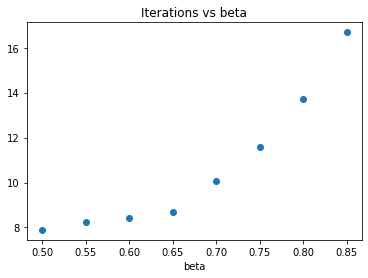

In [15]:
import matplotlib.pyplot as plt
plt.scatter(stepsizes,results)
plt.xlabel('beta')
plt.title('Iterations vs beta')

We now code the distributed method. 


The first step is given in the following chunk of code, which returns P to be the Metropolis matrix on the path. 


In [11]:
import networkx as nx

def adj_to_met(U, dimen):
  #converts adjacency matrix to metropolis matrix

  degs = U.sum(axis=0) #vector of degrees
  

  X = np.zeros((dimen, dimen)) #initialize a zeros dimen x dimen matrix
  
  #loop below sets X[i,j] to be U[i,j] divided by the maximum degrees of i and j, plus one 
  #thus zero entries in U translate to zero entries in X
  #if necessary, can try to rewrite all this in the future so that it does not take quadratic time
  for i in range(dimen):
    for j in range(dimen):
      X[i,j] = float(U[i,j])/float((max(degs[i]+1, degs[j]+1)))
  
  
  #finally, we need to take care of the diagonal entries

  s = X.sum(axis=0) #sum of the rows of X
  d = np.ones(dimen) - s #what remains to make things add up to one 

  X += np.diag(d) #put that remainder on the diagonal and add it to X

  return X

G = nx.grid_graph(dim=(3,3)) #create an nxn path
Q = nx.adjacency_matrix(G)   #adjacency matrix of this path
U = Q.A                      #convert to a numpy array
P = adj_to_met(U, N) 


Now we do the main iteration loop. This is similar to the centralized case above, except that now the "iterate" is a matrix (one column for each agent)
and is updated with a consensus term. 

We stop when the gradient at the running average across network + time is sufficiently close. 

In [12]:
import enlighten

manager = enlighten.get_manager()
ticks = manager.counter(total=L, desc="Outer Loop", unit="Iterations", color="red")

results_dist = np.zeros(L)


for a in range(L):  #there are 11 step-sizes and we loop over them. 
    ticks.update()
    record = np.zeros(times) #this array will contain an entry for every time we run the method 
    tocks = manager.counter(total=times, desc="Inner Loop", unit="Iterations", color="blue")
    for b in range(times): #this loop will fill the "record" array
        
        tocks.update()

        X = np.random.rand(m*d,N) #generate random data 
                                  #this is the a_i in the paper
                                  #each column of this array corresponds to information held by an agent
                                  #thus there are N columns
                                  #each column holds m data points of dimension d

        
        #the next loop generates the quantities b_i from the paper, which we stack into the vector y
        y = np.zeros((m,N)) #there are N agents, each has m data points, so y is m x N
        for i in range(N):
          for j in range(m):
            Xextracted = X[j*d:(j+1)*d,i] #this is x_i
            y[j,i] = np.matmul(ones_vector, Xextracted) + 2*np.random.standard_normal() #y_i = 1^T x_i + w_i 
                                                                                      #this is the all-ones vector is going to be very close to the optimal solution



        #now we setup the main loop

        seqerror = 1 #this quantity will measure the norm of the subgradient
        k=1          #variable counting how many iterations we have done

        xprev = np.zeros((d, N)) #initial point. 
                                 #note the difference from the centralized case
                                 #now the initial point is a dxN matrix
                                 #the i'th column of this matrix is the initial point at node i

        runavg = np.zeros(d)      #running average of iterates
                                  #this is a vector in R^d

        while seqerror > 3e-2: #as long as the error is large, we keep iterating 

              #first step is to compute the gradient at the current point, which is xprev
              grad = np.zeros((d,N)) #initialize to zero
                                     #we will have different gradients at different nodes
                                     #the gradient at node i will be the ith column of this

              #compute the gradients
              for i in range(N):
                for j in range(m):
                  Xextracted = X[j*d:(j+1)*d,i]
                  temp_grad = compute_grad_elastic(xprev[:,i], Xextracted, y[j,i], lambda1, lambda2)
                  grad[:,i] += temp_grad 
                
              #step-size at this iteration

              alpha = 1/( k ** stepsizes[a])
              x = np.zeros((d,N))
              #the main update: first, projected gradient descent
              for i in range(N):
                x[:,i] = projcubenp(xprev[:,i] - alpha*(1/(N*m))*grad[:,i], d) #note the slightly lopsided way we computed the gradient:
                                                              #we sum up over K points, then divide by K
                                                              #thus the ||theta||_2^2 and ||theta||_1 terms get added K times
                                                              #and then get divided by K
              
              
              #second part of main update: the consensus multiplication
              # maybe more helpful to think of this as x <--- (P x^T)^T
              #which works out to the same thing since P is symmetric
              x = np.matmul(x,P)

              xavg = x.sum(axis=1)/N                            #average across the network
              runavg = (1-alpha)*runavg + alpha*xavg            #update the running average 


              #the next part is identical to the centralized case
              gradrun0 = np.zeros(d)
              gradrun1 = np.zeros(d)

              for i in range(N):
                for j in range(m):
                  Xextracted = X[j*d:(j+1)*d,i]
                  temp_grad0 = compute_grad_elastic(runavg, Xextracted, y[j,i], lambda1, 0)
                  temp_grad1 = compute_grad_elastic(runavg, Xextracted, y[j,i], lambda1, lambda2)
                  gradrun0 += temp_grad0
                  gradrun1 += temp_grad1

              #because the above loop summed over N*m data points, we need to now divide by N*m
              gradrun0 = gradrun0/(N*m)
              gradrun1 = gradrun1/(N*m)
              #compute the norm of the subgradient at the running average 
              error_cum = 0 

              for i in range(d):

                if np.absolute(runavg[i]) > 1e-2 and np.absolute(runavg[i]) < 1-1e-2:
                  error_cum += np.absolute(gradrun1[i])

                if np.absolute(runavg[i]) < 1e-2: 
                  error_cum += reluN(gradrun0[i],lambda2)

                if np.absolute(runavg[i]) > 1-1e-2:
                  error_cum += (runavg[i] - projcubescalar(runavg[i]-alpha*gradrun1[i]))/alpha


              seqerror = error_cum #set the cumulative error which will determine whether the while loop takes another iteration 
              xprev = x #update the iterate 
              k=k+1     #update the number of iterations
        record[b]=k     #once the while loop has completed, count how many iterations it took
    tocks.close()       #close the inner loop bar once the for loop over b is complete (it will get started again the next time this loop is passed through)

    results_dist[a] = np.average(record)


manager.stop()


Text(0.5, 1.0, 'Iterations vs beta')

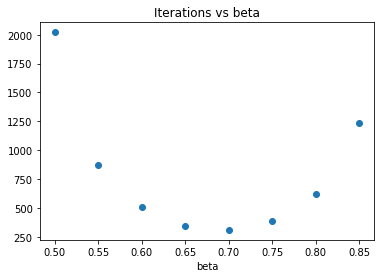

In [14]:
plt.scatter(stepsizes,results_dist)
plt.xlabel('beta')
plt.title('Iterations vs beta')